In [ ]:
pip install transformers datasets evaluate sacrebleu accelerate sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 62.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 98.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 37.3 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset
imdb = load_dataset("imdb")

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks')

In [ ]:
dataset = imdb["train"].train_test_split(train_size=0.9, seed=10)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 22500
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2500
    })
})

In [ ]:
small_train_dataset = imdb["train"].shuffle(seed=42).select([i for i in list(range(3000))])
small_test_dataset = imdb["test"].shuffle(seed=42).select([i for i in list(range(300))])

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [ ]:
def preprocess_function(examples):
   return tokenizer(examples["text"], truncation=True)

tokenized_imdb = dataset.map(preprocess_function, batched=True)


Map:   0%|          | 0/22500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

In [ ]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

In [ ]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.weight', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import numpy as np
from datasets import load_metric

def compute_metrics(eval_pred):
   load_accuracy = load_metric("accuracy")
   load_f1 = load_metric("f1")

   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
   f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
   return {"accuracy": accuracy, "f1": f1}

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from transformers import TrainingArguments, Trainer

repo_name = "finetuning-sentiment-model-distilbert-base-25000-samples"

training_args = TrainingArguments(
   output_dir=repo_name,
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=5,
   weight_decay=0.01,
   save_strategy="epoch",
   logging_strategy="epoch",
   evaluation_strategy="epoch",
   push_to_hub=True,
)

trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_imdb["train"],
   eval_dataset=tokenized_imdb["test"],
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

 [7035/7035 1:27:16, Epoch 5/5]

In [ ]:
trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.272400,0.220713,0.919200,0.920908
2,0.162900,0.255774,0.919200,0.919458
3,0.094700,0.334164,0.924800,0.926677
4,0.054200,0.352348,0.926000,0.927819
5,0.032500,0.379058,0.926000,0.927366


<ipython-input-13-2457e8bb4065>:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  load_accuracy = load_metric("accuracy")


TrainOutput(global_step=7035, training_loss=0.12333626221830996, metrics={'train_runtime': 5240.6688, 'train_samples_per_second': 21.467, 'train_steps_per_second': 1.342, 'total_flos': 1.4748584858256192e+16, 'train_loss': 0.12333626221830996, 'epoch': 5.0})

In [ ]:
trainer.push_to_hub()

'https://huggingface.co/choidf/finetuning-sentiment-model-distilbert-base-25000-samples/tree/main/'

In [ ]:
trainer.state.log_history

[{'loss': 0.2724,
  'learning_rate': 1.6000000000000003e-05,
  'epoch': 1.0,
  'step': 1407},
 {'eval_loss': 0.22071291506290436,
  'eval_accuracy': 0.9192,
  'eval_f1': 0.9209083790133124,
  'eval_runtime': 42.441,
  'eval_samples_per_second': 58.905,
  'eval_steps_per_second': 3.699,
  'epoch': 1.0,
  'step': 1407},
 {'loss': 0.1629, 'learning_rate': 1.2e-05, 'epoch': 2.0, 'step': 2814},
 {'eval_loss': 0.25577354431152344,
  'eval_accuracy': 0.9192,
  'eval_f1': 0.919457735247209,
  'eval_runtime': 42.2951,
  'eval_samples_per_second': 59.108,
  'eval_steps_per_second': 3.712,
  'epoch': 2.0,
  'step': 2814},
 {'loss': 0.0947,
  'learning_rate': 8.000000000000001e-06,
  'epoch': 3.0,
  'step': 4221},
 {'eval_loss': 0.3341638743877411,
  'eval_accuracy': 0.9248,
  'eval_f1': 0.9266770670826833,
  'eval_runtime': 42.2294,
  'eval_samples_per_second': 59.2,
  'eval_steps_per_second': 3.718,
  'epoch': 3.0,
  'step': 4221},
 {'loss': 0.0542,
  'learning_rate': 4.000000000000001e-06,
  'e

In [ ]:
with open("distilBert_log.txt", "w") as outfile:
  outfile.write(f"{trainer.state.log_history}\n")
outfile.close()

In [ ]:
train_loss = { 'train_loss' : []}

In [ ]:

for x in range(0, 5, 2):
  train_loss['train_loss'].append(trainer.state.log_history[x]['loss'])
print(train_loss)

{'train_loss': [0.3784, 0.1891, 0.1099]}


In [ ]:
for i in range(1,3):
  print(i)

1
2


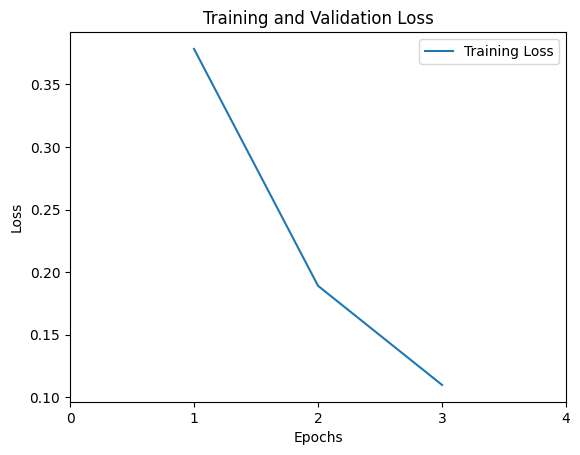

In [ ]:
from matplotlib.pylab import plt
from numpy import arange

# Generate a sequence of integers to represent the epoch numbers
epochs = range(1, 4)

# Plot and label the training and validation loss values
plt.plot(epochs, train_loss['train_loss'], label='Training Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(arange(0, 5, 1))

# Display the plot
plt.legend(loc='best')
plt.show()

In [ ]:
trainer.evaluate()



{'eval_loss': 0.8126330375671387,
 'eval_accuracy': 0.87,
 'eval_f1': 0.8769716088328076,
 'eval_runtime': 8.5337,
 'eval_samples_per_second': 35.155,
 'eval_steps_per_second': 2.226,
 'epoch': 5.0}